<a href="https://colab.research.google.com/github/and-rgr/contradiction_and_entailment/blob/main/dce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# must enable GPU or TPU for Google Colab
# menu Runtime > Change Runtime Type

In [3]:
import tensorflow as tf

In [4]:
troubleshoot = False

if troubleshoot == True:
    python_version = !python --version
    print(python_version[0], '\n')
    print('tensorflow version: ', tf.version.VERSION, '\n')
    nvcc_version = !nvcc --version
    for i in range(len(nvcc_version)):
        print(nvcc_version[i])
    print('')
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
    print(session, '\n')
    gpu_device = tf.test.gpu_device_name()
    print(gpu_device, '\n')
    nvidia_smi = !nvidia-smi
    for row in nvidia_smi:
        print(row)

In [5]:
!ls

sample_data  test.csv  train.csv


In [6]:
!pip install transformers

In [7]:
!pip install sentencepiece

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imported above
# import tensorflow as tf

# requires the sentencepiece package (unsupervised text tokenizer and detokenizer)
from transformers import TFAutoModel,AutoTokenizer

# used for the BertTokenizer
# from transformers import BertTokenizer, TFBertModel

## see the entire dataframe width in the console
pd.set_option('display.expand_frame_repr', False)

## to silence warning - what?
os.environ["WANDB_API_KEY"] = "0"

# check the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU

print('Number of replicas:', strategy.num_replicas_in_sync)

# see available files
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Number of replicas: 1
./train.csv
./test.csv
./.config/.last_update_check.json
./.config/gce
./.config/.last_survey_prompt.yaml
./.config/active_config
./.config/config_sentinel
./.config/.last_opt_in_prompt.yaml
./.config/logs/2022.01.07/14.32.37.114755.log
./.config/logs/2022.01.07/14.33.41.864886.log
./.config/logs/2022.01.07/14.33.42.565580.log
./.config/logs/2022.01.07/14.33.15.504888.log
./.config/logs/2022.01.07/14.33.22.232212.log
./.config/logs/2022.01.07/14.32.57.118850.log
./.config/configurations/config_default
./sample_data/README.md
./sample_data/anscombe.json
./sample_data/mnist_test.csv
./sample_data/california_housing_test.csv
./sample_data/california_housing_train.csv
./sample_data/mnist_train_small.csv


(1000, 6)
(500, 5)
             id                                            premise                                         hypothesis lang_abv   language  label
990  dc6d34e8fc  yeah it's definitely a way out of the way wher...                Yes. There is definitely a way out.       en    English      0
991  f1c261fbe7  for me now the address is the same you know my...                                   I am unemployed.       en    English      2
992  45f0a284fe  go up to state parks with six shelters and lit...  The state parks are almost always kept in good...       en    English      1
993  8f3e2edef2  حسنا ، بالنظر إلى أن بيل برادلي ترعرع في سانت ...                             كان برادلي من أركنساس.       ar     Arabic      2
994  a93da21777  Ve o zaman annesine söyledi, annesi öne doğru ...  Annesinin felçli olduğunu ve yürüyemediğini sö...       tr    Turkish      2
995  896fbf2ec0  Ако достатъчно хора купят тази книга, скоро ще...  Книгата ще се нуждае само от едно представя

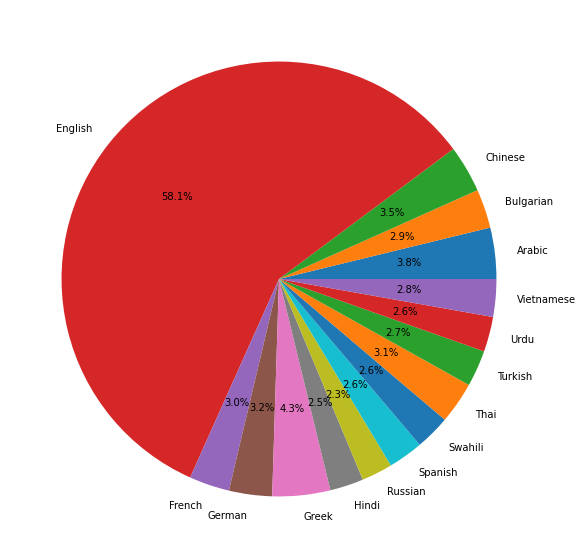

0    348
2    326
1    326
Name: label, dtype: int64


In [9]:
# load data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

# reduce data - optional
train = train.iloc[:1000]
test = test.iloc[:500]


# inspect data
print(train.shape)
print(test.shape)

print(train.tail(10))
print(test.tail(10))

print(train.premise.values[1], '\n', train.hypothesis.values[1], '\n', train.label.values[1])

labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

print(train.label.value_counts())

In [10]:
# Model

# we download a pre-trained tokenizer
# RoBERTa: A Robustly Optimized BERT Pretraining Approach
model_name = "joeddav/xlm-roberta-large-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# might also use
# tokenizer2 = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


# batch_encode_plus() generates a dictionary with the input_ids, token_type_ids and the attention_mask as list for each input sentence
# sentences with different lengths need to be truncated or padded, before combined into a single tensor
# the attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them
# documentation:
#     https://huggingface.co/docs/transformers/internal/tokenization_utils#transformers.tokenization_utils_base.PreTrainedTokenizerBase.batch_encode_plus
train_enc=tokenizer.batch_encode_plus(train[['premise','hypothesis']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)
test_enc=tokenizer.batch_encode_plus(test[['premise','hypothesis']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)

# combine tokenization objects into training and test tensors
# first time this is run, it generates a message about existing devices
# CUDA toolkit installation may require Visual Studio as well
train_tf1=tf.convert_to_tensor(train_enc['input_ids'],dtype=tf.int32)
train_tf2=tf.convert_to_tensor(train_enc['attention_mask'],dtype=tf.int32)
train_input={'input_word_ids':train_tf1,'input_mask':train_tf2}

test_tf1=tf.convert_to_tensor(test_enc['input_ids'],dtype=tf.int32)
test_tf2=tf.convert_to_tensor(test_enc['attention_mask'],dtype=tf.int32)
test_input={'input_word_ids':test_tf1,'input_mask':test_tf2}

print(train_enc[10])

Encoding(num_tokens=100, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [11]:
# because error
# os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

# QUESTION - what does strategy.scope() do?
with strategy.scope():
    # instantiates a Keras tensor
    input_ids = tf.keras.Input(shape = (100,), dtype = tf.int32, name = 'input_word_ids')
    input_mask = tf.keras.Input(shape = (100,), dtype = tf.int32, name = 'input_mask')

    # documentation: https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel
    roberta = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    # at this point roberta([input_ids,input_mask]) is a tensorflow object, that contains two keras tensors
    # QUESTION - what does this do??
    # 1st dimension of input_ids, input_masks
    roberta = roberta([input_ids,input_mask])[0]

    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D
    # "Global average pooling operation for temporal data"
    # https://stackoverflow.com/questions/54493738/keras-difference-between-averagepooling1d-layer-and-globalaveragepooling1d-laye
    # QUESTION - is average pooling similar to max pooling for convolution networks?
    # downsampling
    # prevents overfitting
    output = tf.keras.layers.GlobalAveragePooling1D()(roberta)
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
    # "regular densely-connected NN layer"
    output = tf.keras.layers.Dense(3, activation = 'softmax')(output)

    model = tf.keras.Model(inputs = [input_ids,input_mask], outputs = output)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-5),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    model.summary()


Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 tfxlm_roberta_model (TFXLMRobe  TFBaseModelOutputWi  559890432  ['input_word_ids[0][0]',         
 rtaModel)                      thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True, verbose=1, monitor='val_accuracy')

In [13]:
# train the model?
# uses up space on D: for some reason
# model.fit(train_input,train.label,validation_split = 0.2,epochs=20,batch_size=16*strategy.num_replicas_in_sync,callbacks=[early_stop],verbose=1)
model.fit(train_input,train.label,validation_split = 0.2,epochs=10,batch_size=16*strategy.num_replicas_in_sync,verbose=1)

# WARNING:tensorflow:Gradients do not exist for variables ['tfxlm_roberta_model/roberta/pooler/dense/kernel:0', 'tfxlm_roberta_model/roberta/pooler/dense/bias:0'] when minimizing the loss.


Epoch 1/10
50/50 [==============================] - 85s 1s/step - loss: 0.3577 - accuracy: 0.8875 - val_loss: 0.2218 - val_accuracy: 0.9200
Epoch 2/10
50/50 [==============================] - 64s 1s/step - loss: 0.1062 - accuracy: 0.9725 - val_loss: 0.3023 - val_accuracy: 0.9250
Epoch 3/10
50/50 [==============================] - 64s 1s/step - loss: 0.0403 - accuracy: 0.9900 - val_loss: 0.3699 - val_accuracy: 0.9300
Epoch 4/10
50/50 [==============================] - 64s 1s/step - loss: 0.0367 - accuracy: 0.9875 - val_loss: 0.4506 - val_accuracy: 0.9050
Epoch 5/10
50/50 [==============================] - 64s 1s/step - loss: 0.0547 - accuracy: 0.9837 - val_loss: 0.3560 - val_accuracy: 0.9100
Epoch 6/10
50/50 [==============================] - 64s 1s/step - loss: 0.0199 - accuracy: 0.9925 - val_loss: 0.3725 - val_accuracy: 0.9250
Epoch 7/10
50/50 [==============================] - 64s 1s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4316 - val_accuracy: 0.9300
Epoch 8/10
50/50 [==

In [ ]:
pred=[np.argmax(i) for i in model.predict(test_input)]
print(pd.DataFrame(pred).value_counts())

pd.DataFrame({'id':test.id,
              'prediction':pred}).to_csv('submission.csv',index=False)

In [ ]:
# https://datascience.stackexchange.com/questions/42599/what-is-the-relationship-between-the-accuracy-and-the-loss-in-deep-learning